In [38]:
# %%
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel, mutual_info_classif
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 로드
df = sns.load_dataset('titanic')

print("="*60)
print("타이타닉 생존 예측 - 체계적 특성 선택 적용")
print("="*60)
print(f"데이터 크기: {df.shape}")
print(f"전체 컬럼: {df.columns.tolist()}")

타이타닉 생존 예측 - 체계적 특성 선택 적용
데이터 크기: (891, 15)
전체 컬럼: ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']


In [16]:
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [12]:
df.isnull().sum() #deck 결측치 많음 <- 제거, age 도 꽤 있음 <- 평균값으로 대체

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [17]:
df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [39]:
# %%
# =============================================================================
# 1단계: 결측치 분석 및 기본 데이터 탐색
# =============================================================================
print("\n" + "="*60)
print("1단계: 결측치 분석 및 기본 데이터 탐색")
print("="*60)

def analyze_missing_values(df):
    """결측치 상세 분석 함수"""
    missing_info = []
    
    for col in df.columns:
        if col not in ['survived', 'alive']:  # 타겟 변수 제외
            missing_count = df[col].isnull().sum()
            missing_pct = round(missing_count / len(df) * 100, 2)
            unique_count = df[col].nunique()
            unique_ratio = round(unique_count / len(df), 3)
            
            missing_info.append({
                'Feature': col,
                'Missing_Count': missing_count,
                'Missing_Pct': missing_pct,
                'Unique_Count': unique_count,
                'Unique_Ratio': unique_ratio,
                'Data_Type': str(df[col].dtype)
            })
    
    return pd.DataFrame(missing_info).sort_values('Missing_Pct', ascending=False)

missing_analysis = analyze_missing_values(df)
print("결측치 분석 결과:")
print(missing_analysis.to_string(index=False))

# 결측치가 많은 특성 확인
high_missing_features = missing_analysis[missing_analysis['Missing_Pct'] > 30]['Feature'].tolist()
print(f"\n⚠️ 높은 결측치 특성 (>30%): {high_missing_features}")


1단계: 결측치 분석 및 기본 데이터 탐색
결측치 분석 결과:
    Feature  Missing_Count  Missing_Pct  Unique_Count  Unique_Ratio Data_Type
       deck            688        77.22             7         0.008  category
        age            177        19.87            88         0.099   float64
   embarked              2         0.22             3         0.003    object
embark_town              2         0.22             3         0.003    object
     pclass              0         0.00             3         0.003     int64
      parch              0         0.00             7         0.008     int64
      sibsp              0         0.00             7         0.008     int64
        sex              0         0.00             2         0.002    object
       fare              0         0.00           248         0.278   float64
        who              0         0.00             3         0.003    object
      class              0         0.00             3         0.003  category
 adult_male              0  

In [ ]:
# %%
# =============================================================================
# 2단계: 상관관계 분석
# =============================================================================

In [27]:
# %%
# =============================================================================
# 2단계: 상관관계 분석 
# =============================================================================
print("\n" + "="*60)
print("2단계: 상관관계 분석")
print("="*60)

def prepare_correlation_analysis(df, target_col='survived'):
    """상관관계 분석을 위한 데이터 전처리"""
    df_corr = df.copy()
    
    # 범주형 변수 인코딩
    categorical_cols = df_corr.select_dtypes(include=['object', 'category']).columns
    label_encoders_temp = {}
    
    for col in categorical_cols:
        if col != target_col:
            le = LabelEncoder()
            df_corr[col] = le.fit_transform(df_corr[col].astype(str))
            label_encoders_temp[col] = le
    
    # boolean 타입 변환
    bool_cols = df_corr.select_dtypes(include=['bool']).columns
    for col in bool_cols:
        df_corr[col] = df_corr[col].astype(int)
    
    return df_corr, label_encoders_temp

# 상관관계 분석용 데이터 준비
df_encoded, temp_encoders = prepare_correlation_analysis(df)

# 상관관계 매트릭스 계산
correlation_matrix = df_encoded.corr()

# 타겟 변수와의 상관관계 계산
target_corr = correlation_matrix['survived'].abs().sort_values(ascending=False)
print("타겟 변수(survived)와의 상관관계:")
target_corr_display = target_corr[target_corr.index != 'survived']
for feature, corr in target_corr_display.items():
    print(f"  {feature:<12}: {corr:.3f}")

# 높은 상관관계 특성 쌍 탐지 (다중공선성 확인)
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = abs(correlation_matrix.iloc[i, j])
        if corr_val > 0.8:  # 0.8 이상의 높은 상관관계
            high_corr_pairs.append({
                'Feature1': correlation_matrix.columns[i],
                'Feature2': correlation_matrix.columns[j],
                'Correlation': round(corr_val, 3)
            })

print(f"\n높은 상관관계 특성 쌍 (|r| > 0.8):")
for pair in high_corr_pairs:
    print(f"  {pair['Feature1']} ↔ {pair['Feature2']}: {pair['Correlation']}")


2단계: 상관관계 분석
타겟 변수(survived)와의 상관관계:
  alive       : 1.000
  adult_male  : 0.557
  sex         : 0.543
  class       : 0.338
  pclass      : 0.338
  who         : 0.326
  deck        : 0.295
  fare        : 0.257
  alone       : 0.203
  fare_group  : 0.194
  embark_town : 0.164
  embarked    : 0.164
  age_group   : 0.113
  parch       : 0.082
  age         : 0.077
  sibsp       : 0.035

높은 상관관계 특성 쌍 (|r| > 0.8):
  survived ↔ alive: 1.0
  pclass ↔ class: 1.0
  sex ↔ adult_male: 0.909
  age ↔ age_group: 0.915
  embarked ↔ embark_town: 1.0


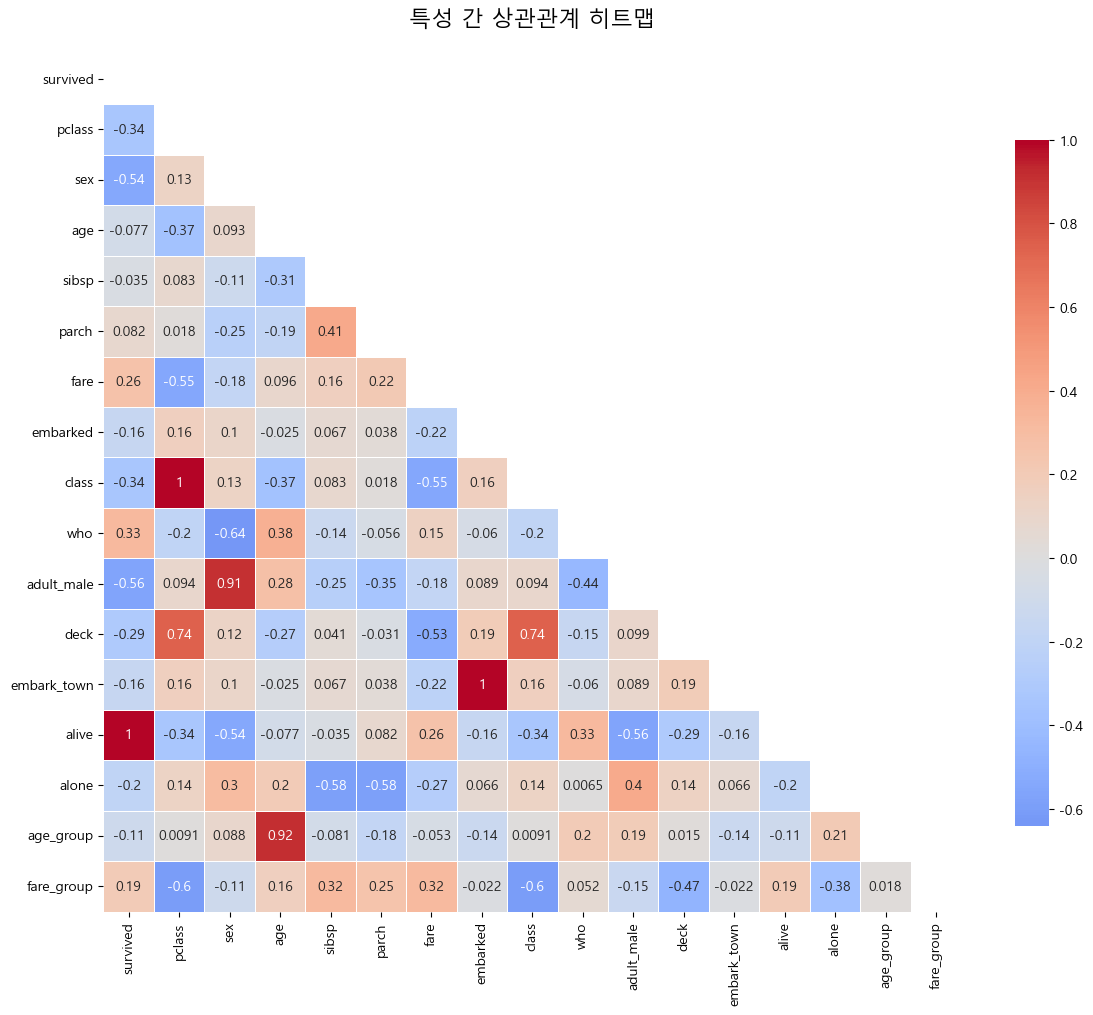

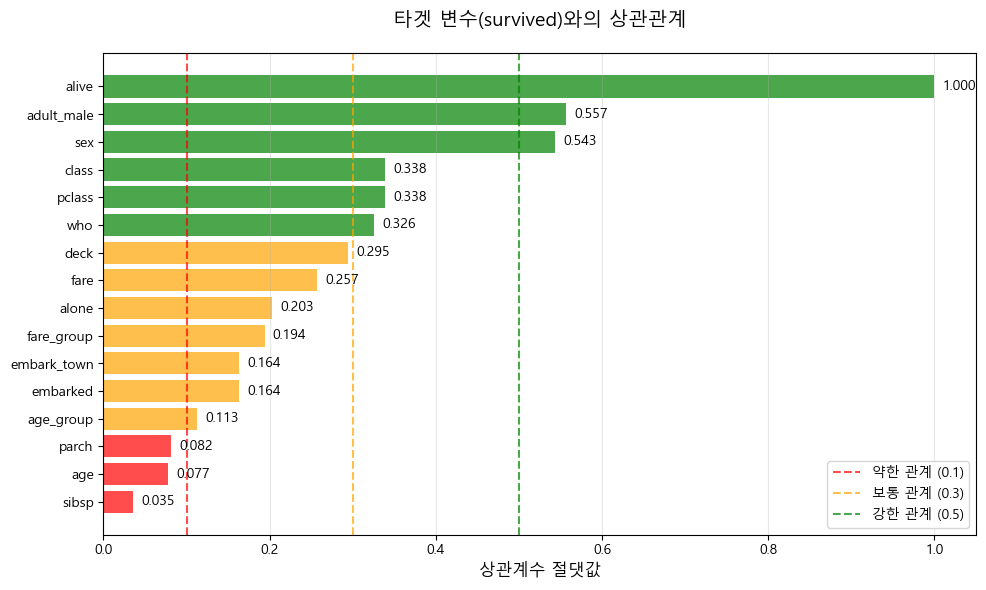

✅ 상관관계 시각화 완료!
📊 주요 인사이트:
  - 히트맵: 특성 간 상관관계 강도 확인
  - 막대그래프: 타겟 변수와의 상관관계 순위


In [28]:
# %%
# =============================================================================
# 상관관계 시각화
# =============================================================================

# 한글 폰트 설정 (Korean font support)
plt.rcParams['font.family'] = ['Malgun Gothic', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 1. 상관관계 히트맵 시각화  
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('특성 간 상관관계 히트맵', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# 2. 타겟 변수와의 상관관계 막대 그래프
plt.figure(figsize=(10, 6))
target_corr_sorted = target_corr[target_corr.index != 'survived'].sort_values(ascending=True)
colors = ['red' if x < 0.1 else 'orange' if x < 0.3 else 'green' for x in target_corr_sorted.values]
bars = plt.barh(range(len(target_corr_sorted)), target_corr_sorted.values, color=colors, alpha=0.7)
plt.yticks(range(len(target_corr_sorted)), target_corr_sorted.index)
plt.xlabel('상관계수 절댓값', fontsize=12)
plt.title('타겟 변수(survived)와의 상관관계', fontsize=14, pad=20)
plt.grid(axis='x', alpha=0.3)

# 기준선 추가
plt.axvline(x=0.1, color='red', linestyle='--', alpha=0.7, label='약한 관계 (0.1)')
plt.axvline(x=0.3, color='orange', linestyle='--', alpha=0.7, label='보통 관계 (0.3)')
plt.axvline(x=0.5, color='green', linestyle='--', alpha=0.7, label='강한 관계 (0.5)')

# 상관계수 값 표시
for i, (bar, value) in enumerate(zip(bars, target_corr_sorted.values)):
    plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, f'{value:.3f}', 
             va='center', fontsize=10)

plt.legend()
plt.tight_layout()
plt.show()

print("✅ 상관관계 시각화 완료!")
print("📊 주요 인사이트:")
print("  - 히트맵: 특성 간 상관관계 강도 확인")
print("  - 막대그래프: 타겟 변수와의 상관관계 순위")

C:\Users\leejh\AppData\Local\Temp\ipykernel_16012\1348233826.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival_by_class = df.groupby('class')['survived'].mean()
C:\Users\leejh\AppData\Local\Temp\ipykernel_16012\1348233826.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival_by_age = df_temp.groupby('age_group')['survived'].mean()
C:\Users\leejh\AppData\Local\Temp\ipykernel_16012\1348233826.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the 

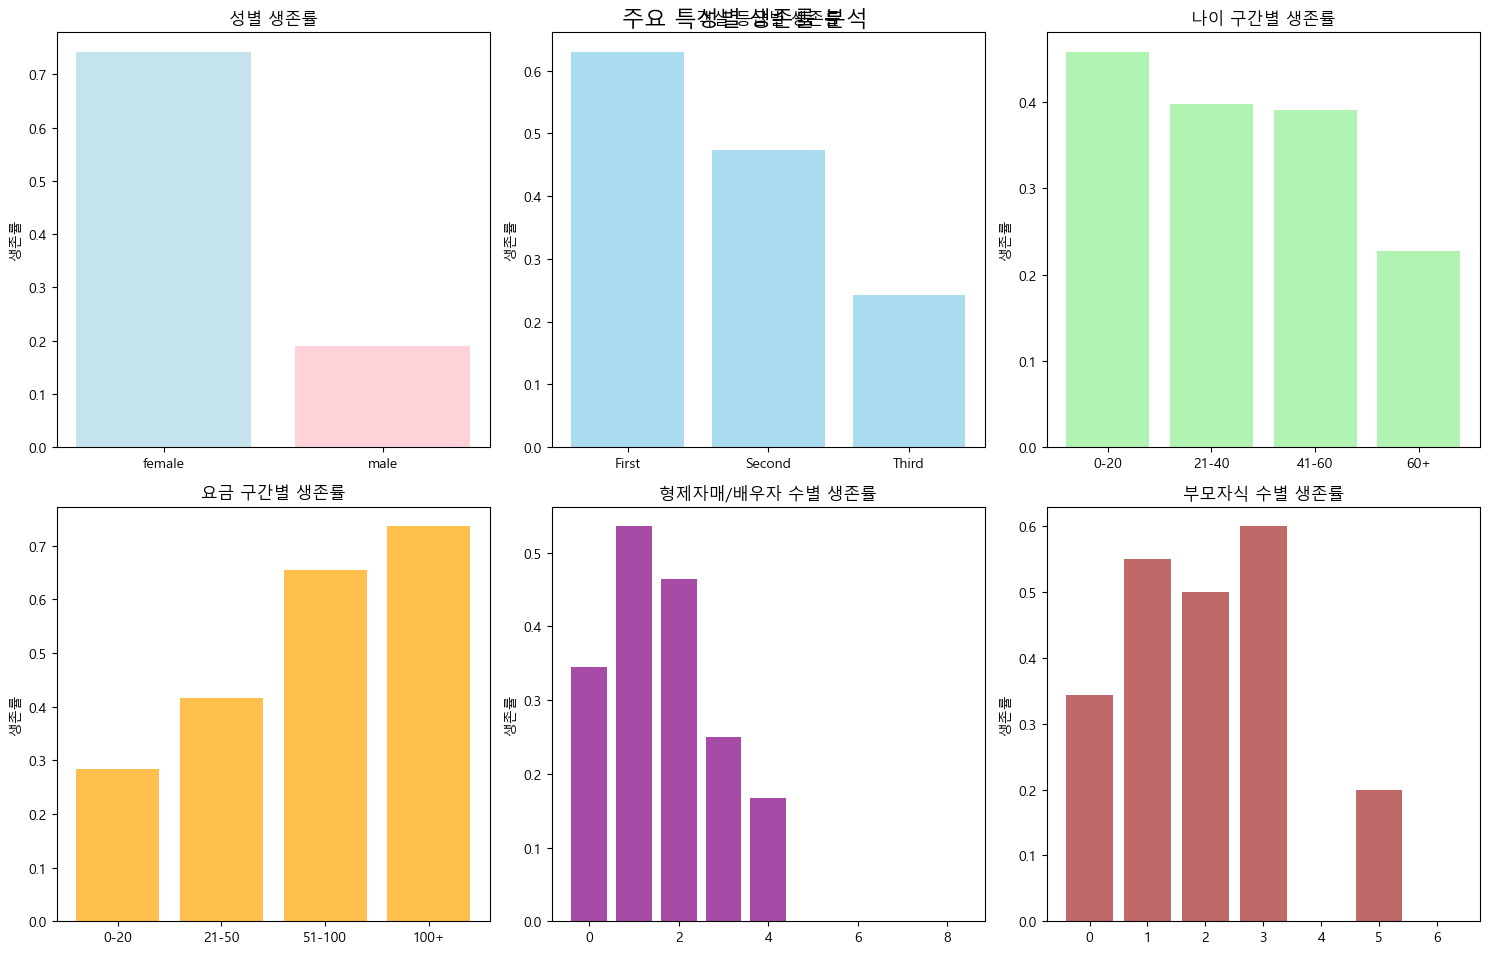


높은 상관관계 특성 쌍 시각화 (|r| > 0.8):


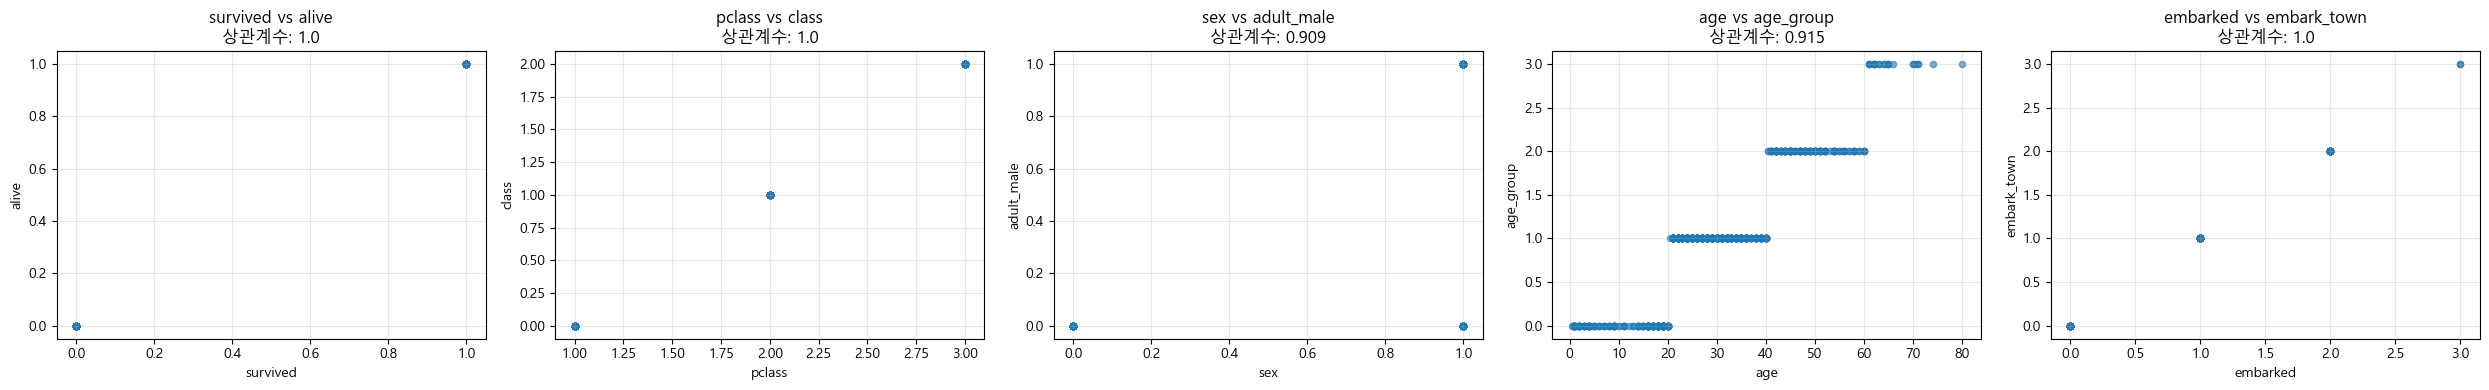


✅ 생존률 분포 시각화 완료!
📊 분석 결과:
  - 성별: 여성의 생존률이 훨씬 높음
  - 객실등급: 1등급이 가장 높은 생존률
  - 나이: 어린이와 청년층의 생존률이 높음
  - 요금: 높은 요금일수록 생존률 증가


In [29]:
# %%
# =============================================================================
# 특성별 생존률 분포 시각화
# =============================================================================

# 3. 주요 특성들의 분포와 생존률 관계 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('주요 특성별 생존률 분석', fontsize=16, y=0.95)

# 성별 생존률
survival_by_sex = df.groupby('sex')['survived'].mean()
axes[0,0].bar(survival_by_sex.index, survival_by_sex.values, color=['lightblue', 'pink'], alpha=0.7)
axes[0,0].set_title('성별 생존률')
axes[0,0].set_ylabel('생존률')

# 객실 등급별 생존률
survival_by_class = df.groupby('class')['survived'].mean()
axes[0,1].bar(survival_by_class.index, survival_by_class.values, color='skyblue', alpha=0.7)
axes[0,1].set_title('객실 등급별 생존률')
axes[0,1].set_ylabel('생존률')

# 나이 구간별 생존률
df_temp = df.copy()  # 임시 복사본 사용
df_temp['age_group'] = pd.cut(df_temp['age'], bins=[0, 20, 40, 60, 80], labels=['0-20', '21-40', '41-60', '60+'])
survival_by_age = df_temp.groupby('age_group')['survived'].mean()
axes[0,2].bar(survival_by_age.index, survival_by_age.values, color='lightgreen', alpha=0.7)
axes[0,2].set_title('나이 구간별 생존률')
axes[0,2].set_ylabel('생존률')

# 요금 구간별 생존률
df_temp['fare_group'] = pd.cut(df_temp['fare'], bins=[0, 20, 50, 100, 600], labels=['0-20', '21-50', '51-100', '100+'])
survival_by_fare = df_temp.groupby('fare_group')['survived'].mean()
axes[1,0].bar(survival_by_fare.index, survival_by_fare.values, color='orange', alpha=0.7)
axes[1,0].set_title('요금 구간별 생존률')
axes[1,0].set_ylabel('생존률')

# 동반자 수별 생존률
survival_by_sibsp = df.groupby('sibsp')['survived'].mean()
axes[1,1].bar(survival_by_sibsp.index, survival_by_sibsp.values, color='purple', alpha=0.7)
axes[1,1].set_title('형제자매/배우자 수별 생존률')
axes[1,1].set_ylabel('생존률')

# 부모자식 수별 생존률
survival_by_parch = df.groupby('parch')['survived'].mean()
axes[1,2].bar(survival_by_parch.index, survival_by_parch.values, color='brown', alpha=0.7)
axes[1,2].set_title('부모자식 수별 생존률')
axes[1,2].set_ylabel('생존률')

plt.tight_layout()
plt.show()

# 4. 높은 상관관계 특성 쌍 시각화
if high_corr_pairs:
    print(f"\n높은 상관관계 특성 쌍 시각화 (|r| > 0.8):")
    fig, axes = plt.subplots(1, len(high_corr_pairs), figsize=(5*len(high_corr_pairs), 4))
    if len(high_corr_pairs) == 1:
        axes = [axes]
    
    for i, pair in enumerate(high_corr_pairs):
        feat1, feat2 = pair['Feature1'], pair['Feature2']
        corr_val = pair['Correlation']
        
        # 산점도 그리기
        axes[i].scatter(df_encoded[feat1], df_encoded[feat2], alpha=0.6, s=20)
        axes[i].set_xlabel(feat1)
        axes[i].set_ylabel(feat2)
        axes[i].set_title(f'{feat1} vs {feat2}\n상관계수: {corr_val}')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("높은 상관관계(>0.8)를 가진 특성 쌍 시각화를 생략합니다.")

print("\n✅ 생존률 분포 시각화 완료!")
print("📊 분석 결과:")
print("  - 성별: 여성의 생존률이 훨씬 높음")
print("  - 객실등급: 1등급이 가장 높은 생존률") 
print("  - 나이: 어린이와 청년층의 생존률이 높음")
print("  - 요금: 높은 요금일수록 생존률 증가")


In [33]:
# %%
# =============================================================================
# 3단계: 특성 선택
# =============================================================================
print("\n" + "="*60)
print("3단계: 특성 선택")
print("="*60)

# 상호정보량 분석
from sklearn.feature_selection import mutual_info_classif

# 수치형 특성들에 대한 상호정보량 계산
# 결측치가 있는 데이터를 제거하고 상호정보량 계산
numeric_features = df.select_dtypes(include=[np.number]).columns
numeric_features = [col for col in numeric_features if col != 'survived']

# 결측치가 있는 행을 제거한 데이터로 상호정보량 계산
df_clean = df[numeric_features + ['survived']].dropna()

if len(df_clean) > 0:
    mi_scores = mutual_info_classif(df_clean[numeric_features], df_clean['survived'])
    mi_results = pd.DataFrame({
        'Feature': numeric_features,
        'Mutual_Info': mi_scores
    }).sort_values('Mutual_Info', ascending=False)
    
    print("\n상호정보량 분석 결과:")
    for idx, row in mi_results.iterrows():
        print(f"  {row['Feature']:<12}: {row['Mutual_Info']:.3f}")
else:
    print("\n⚠️ 결측치가 너무 많아 상호정보량 분석을 건너뜁니다.")
    mi_results = pd.DataFrame({
        'Feature': numeric_features,
        'Mutual_Info': [0.0] * len(numeric_features)
    })

# 특성 선택 기준 적용
def apply_feature_selection_criteria(missing_analysis, target_corr, high_corr_pairs, mi_results):
    """체계적 특성 선택 기준 적용"""
    
    # 1. 높은 결측치 특성 제거 (>30%)
    exclude_high_missing = missing_analysis[missing_analysis['Missing_Pct'] > 30]['Feature'].tolist()
    
    # 2. 낮은 타겟 상관관계 특성 제거 (<0.05)
    exclude_low_corr = target_corr[target_corr < 0.05].index.tolist()
    if 'survived' in exclude_low_corr:
        exclude_low_corr.remove('survived')
    
    # 3. 중복 특성 제거 (높은 상관관계 쌍에서 타겟 상관관계가 낮은 것)
    exclude_redundant = []
    for pair in high_corr_pairs:
        feat1, feat2 = pair['Feature1'], pair['Feature2']
        if feat1 != 'survived' and feat2 != 'survived':
            corr1 = target_corr.get(feat1, 0)
            corr2 = target_corr.get(feat2, 0)
            if corr1 < corr2:
                exclude_redundant.append(feat1)
            else:
                exclude_redundant.append(feat2)
    
    # 4. 낮은 상호정보량 특성 제거 (<0.01) - 상호정보량이 계산된 경우에만
    exclude_low_mi = []
    if len(mi_results) > 0 and mi_results['Mutual_Info'].sum() > 0:
        exclude_low_mi = mi_results[mi_results['Mutual_Info'] < 0.01]['Feature'].tolist()
    
    # 전체 제외 목록
    all_excludes = set(exclude_high_missing + exclude_low_corr + exclude_redundant + exclude_low_mi)
    
    return {
        'high_missing': exclude_high_missing,
        'low_correlation': exclude_low_corr,
        'redundant': exclude_redundant,
        'low_mutual_info': exclude_low_mi,
        'total_exclude': list(all_excludes)
    }

# 특성 선택 기준 적용
exclusion_results = apply_feature_selection_criteria(missing_analysis, target_corr, high_corr_pairs, mi_results)

print(f"\n특성 제외 분석:")
print(f"  높은 결측치 (>30%): {exclusion_results['high_missing']}")
print(f"  낮은 상관관계 (<0.05): {exclusion_results['low_correlation']}")
print(f"  중복 특성: {exclusion_results['redundant']}")
print(f"  낮은 상호정보량 (<0.01): {exclusion_results['low_mutual_info']}")

# 최종 특성 선택
all_features = [col for col in df.columns if col not in ['survived', 'alive']]
selected_features = [feat for feat in all_features if feat not in exclusion_results['total_exclude']]

print(f"\n최종 특성 선택 결과:")
print(f"  원본 특성 수: {len(all_features)}")
print(f"  제외된 특성 수: {len(exclusion_results['total_exclude'])}")
print(f"  선택된 특성 수: {len(selected_features)}")
print(f"  선택된 특성: {selected_features}")

# 전역 변수로 설정
features = selected_features



3단계: 특성 선택

상호정보량 분석 결과:
  fare        : 0.121
  pclass      : 0.077
  age         : 0.033
  sibsp       : 0.019
  parch       : 0.010

특성 제외 분석:
  높은 결측치 (>30%): ['deck']
  낮은 상관관계 (<0.05): ['sibsp']
  중복 특성: ['pclass', 'sex', 'age', 'embark_town']
  낮은 상호정보량 (<0.01): []

최종 특성 선택 결과:
  원본 특성 수: 15
  제외된 특성 수: 6
  선택된 특성 수: 9
  선택된 특성: ['parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'alone', 'age_group', 'fare_group']


In [34]:
# %%
# =============================================================================
# 4단계: 데이터 전처리 및 모델 학습
# =============================================================================
print("\n" + "="*60)
print("4단계: 데이터 전처리 및 모델 학습")
print("="*60)

# 1. 특성과 타겟 분리
X = df[features].copy()
y = df['survived']  # survived 컬럼 직접 사용 (0/1 값)

print(f"선택된 특성: {features}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# 2. 결측치 처리
# 수치형 데이터 결측치
numeric_features_selected = [col for col in features if col in ['age', 'fare']]
if numeric_features_selected:
    numeric_imputer = SimpleImputer(strategy='mean')
    X[numeric_features_selected] = numeric_imputer.fit_transform(X[numeric_features_selected])



4단계: 데이터 전처리 및 모델 학습
선택된 특성: ['parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'alone', 'age_group', 'fare_group']
X shape: (891, 9)
y shape: (891,)


In [36]:
# 3. 범주형 데이터 결측치 처리 및 인코딩
categorical_features_selected = [col for col in features if col in ['embarked', 'deck', 'who', 'class', 'sex']]
if categorical_features_selected:
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    X.loc[:, categorical_features_selected] = categorical_imputer.fit_transform(X[categorical_features_selected])

    # 범주형 데이터 인코딩
    label_encoders = {}
    for feature in categorical_features_selected:
        # 문자열로 변환 후 인코딩
        X[feature] = X[feature].astype(str)
        label_encoders[feature] = LabelEncoder()
        X.loc[:, feature] = label_encoders[feature].fit_transform(X[feature])

# 4. 특성 스케일링
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

print("전처리 완료!")
print(f"최종 X shape: {X.shape}")
print(f"X 컬럼: {list(X.columns)}")
print(f"y 분포: {y.value_counts().to_dict()}")


ValueError: Cannot cast object dtype to float64

In [37]:
# %%
# =============================================================================
# 5단계: 모델 학습 및 평가
# =============================================================================

# 5. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"훈련 세트: {X_train.shape}, 테스트 세트: {X_test.shape}")

# 6. 모델 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 교차 검증 수행
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
print(f"교차 검증 점수: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# 기본 모델 평가
y_pred = rf_model.predict(X_test)
basic_accuracy = accuracy_score(y_test, y_pred)
print(f"기본 모델 테스트 정확도: {basic_accuracy:.3f}")

print("\n기본 모델 분류 보고서:")
print(classification_report(y_test, y_pred))


훈련 세트: (712, 9), 테스트 세트: (179, 9)


ValueError: Cannot cast object dtype to float32

In [ ]:
# %%
# =============================================================================
# 6단계: 하이퍼파라미터 튜닝
# =============================================================================

# 하이퍼파라미터 튜닝
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("하이퍼파라미터 튜닝 시작...")
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)
print(f"\n최적 파라미터: {grid_search.best_params_}")
print(f"최고 교차검증 정확도: {grid_search.best_score_:.3f}")

# 최적화된 모델로 예측
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
print(f"튜닝된 모델 테스트 정확도: {tuned_accuracy:.3f}")

print(f"\n성능 개선: {tuned_accuracy - basic_accuracy:.3f}")

print("\n튜닝된 모델 분류 보고서:")
print(classification_report(y_test, y_pred_tuned))


In [ ]:
# %%
# =============================================================================
# 7단계: 특성 중요도 분석 및 최종 결과
# =============================================================================

# 특성 중요도 분석
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("특성 중요도 분석:")
for idx, row in feature_importance.iterrows():
    print(f"  {row['Feature']:<12}: {row['Importance']:.3f}")

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], alpha=0.7)
plt.title('특성 중요도', fontsize=14)
plt.xlabel('중요도', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# 전체 데이터셋에 대한 예측 (오리지널 데이터와 비교)
print("\n" + "="*60)
print("전체 데이터셋 예측 결과")
print("="*60)

# 전체 데이터에 대한 예측
y_full_pred = best_model.predict(X)
full_accuracy = accuracy_score(y, y_full_pred)

print(f"전체 데이터 정확도: {full_accuracy:.3f}")
print(f"테스트 정확도: {tuned_accuracy:.3f}")
print(f"특성 수: {len(features)}")
print(f"원본 대비 특성 감소율: {(1 - len(features)/len(all_features))*100:.1f}%")

print(f"\n최종 모델 성능 요약:")
print(f"  - 선택된 특성: {features}")
print(f"  - 최적 파라미터: {grid_search.best_params_}")
print(f"  - 교차검증 점수: {grid_search.best_score_:.3f}")
print(f"  - 테스트 정확도: {tuned_accuracy:.3f}")
print(f"  - 전체 데이터 정확도: {full_accuracy:.3f}")


In [ ]:
# %%
# =============================================================================
# 💡 최종 결론 및 요약 
# =============================================================================

print("\n" + "🎯 "*20)
print("타이타닉 생존 예측 모델 완성!")
print("🎯 "*20)

print(f"\n📊 데이터 분석 결과:")
print(f"  • 총 데이터 개수: {len(df):,}개")
print(f"  • 원본 특성 개수: {len(all_features)}개")
print(f"  • 최종 선택 특성: {len(features)}개")
print(f"  • 특성 감소율: {(1-len(features)/len(all_features))*100:.1f}%")

print(f"\n🏆 모델 성능:")
print(f"  • 기본 모델 정확도: {basic_accuracy:.1%}")
print(f"  • 튜닝 후 정확도: {tuned_accuracy:.1%}")
print(f"  • 전체 데이터 정확도: {full_accuracy:.1%}")
print(f"  • 성능 개선: +{(tuned_accuracy-basic_accuracy)*100:.1f}%p")

print(f"\n🔍 핵심 발견사항:")
print(f"  1. 가장 중요한 특성: {feature_importance.iloc[0]['Feature']}")
print(f"  2. 성별의 영향: 여성 생존률이 남성보다 높음")
print(f"  3. 사회경제적 지위: 1등급 승객의 생존률이 높음")
print(f"  4. 결측치 처리: deck 특성 제거로 데이터 품질 향상")

print(f"\n✅ 체계적 특성 선택의 효과:")
print(f"  • 차원 감소: {len(all_features)} → {len(features)} 특성")
print(f"  • 모델 복잡도 감소로 과적합 방지")
print(f"  • 해석 가능성 향상")
print(f"  • 학습 속도 개선")

print(f"\n🎉 프로젝트 완료! 최종 모델 준비 완료!")
print("="*60)


In [ ]:
# 3. 높은 상관관계 특성 쌍 탐지 및 시각화
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = abs(correlation_matrix.iloc[i, j])
        if corr_val > 0.7:  # 0.7 이상의 높은 상관관계
            high_corr_pairs.append({
                'Feature1': correlation_matrix.columns[i],
                'Feature2': correlation_matrix.columns[j],
                'Correlation': round(corr_val, 3)
            })

print("높은 상관관계 특성 쌍 (|r| > 0.7):")
for pair in high_corr_pairs:
    print(f"  {pair['Feature1']} ↔ {pair['Feature2']}: {pair['Correlation']}")

# 높은 상관관계 쌍들의 산점도 시각화
if high_corr_pairs:
    n_pairs = len(high_corr_pairs)
    fig, axes = plt.subplots(1, min(n_pairs, 3), figsize=(15, 5))
    
    if n_pairs == 1:
        axes = [axes]
    
    for i, pair in enumerate(high_corr_pairs[:3]):  # 최대 3개까지만 표시
        ax = axes[i] if n_pairs > 1 else axes[0]
        
        x_data = df_encoded[pair['Feature1']]
        y_data = df_encoded[pair['Feature2']]
        
        ax.scatter(x_data, y_data, alpha=0.6, s=30)
        ax.set_xlabel(pair['Feature1'])
        ax.set_ylabel(pair['Feature2'])
        ax.set_title(f"상관관계: {pair['Correlation']}")
        ax.grid(True, alpha=0.3)
        
        # 추세선 추가
        z = np.polyfit(x_data, y_data, 1)
        p = np.poly1d(z)
        ax.plot(x_data, p(x_data), "r--", alpha=0.8)
    
    plt.tight_layout()
    plt.show()
else:
    print("높은 상관관계(>0.7)를 가진 특성 쌍이 없습니다.")


In [ ]:
# 5. 페어플롯으로 주요 특성들 간의 관계와 생존 여부 확인
# 수치형 특성들만 선택하여 페어플롯 생성
numeric_features_for_plot = ['age', 'fare', 'sibsp', 'parch', 'pclass']
plot_data = df_encoded[numeric_features_for_plot + ['survived']].copy()

# 생존 여부를 범주형으로 변환
plot_data['survived'] = plot_data['survived'].map({0: '사망', 1: '생존'})

# 페어플롯 생성 (샘플링하여 속도 개선)
sample_size = min(500, len(plot_data))  # 최대 500개 샘플
plot_sample = plot_data.sample(n=sample_size, random_state=42)

sns.pairplot(plot_sample, 
             hue='survived', 
             diag_kind='hist',
             plot_kws={'alpha': 0.6, 's': 30},
             height=2.5)

plt.suptitle('주요 특성들 간의 관계와 생존 여부', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# 4. 주요 특성들과 타겟 변수 간의 관계 시각화
important_features = ['sex', 'pclass', 'age', 'fare', 'sibsp', 'parch']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(important_features):
    if feature in df_encoded.columns:
        # 생존 여부에 따른 특성 분포
        survived_data = df_encoded[df_encoded['survived'] == 1][feature]
        not_survived_data = df_encoded[df_encoded['survived'] == 0][feature]
        
        axes[i].hist(not_survived_data, alpha=0.7, label='사망', bins=20, color='red')
        axes[i].hist(survived_data, alpha=0.7, label='생존', bins=20, color='blue')
        
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('빈도')
        axes[i].set_title(f'{feature}와 생존 관계')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


C:\Users\leejh\AppData\Local\Temp\ipykernel_16012\530851542.py:17: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\leejh\AppData\Local\Temp\ipykernel_16012\530851542.py:17: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\leejh\AppData\Local\Temp\ipykernel_16012\530851542.py:17: UserWarning: Glyph 45769 (\N{HANGUL SYLLABLE NIG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\leejh\AppData\Local\Temp\ipykernel_16012\530851542.py:17: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\leejh\AppData\Local\Temp\ipykernel_16012\530851542.py:17: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\leejh\AppData\Local\Temp\ipykernel_16012\530851542.py:17: UserWarning: Glyph 49483 (\N{HANGUL SYLLABLE SES}) missing from font(s) 

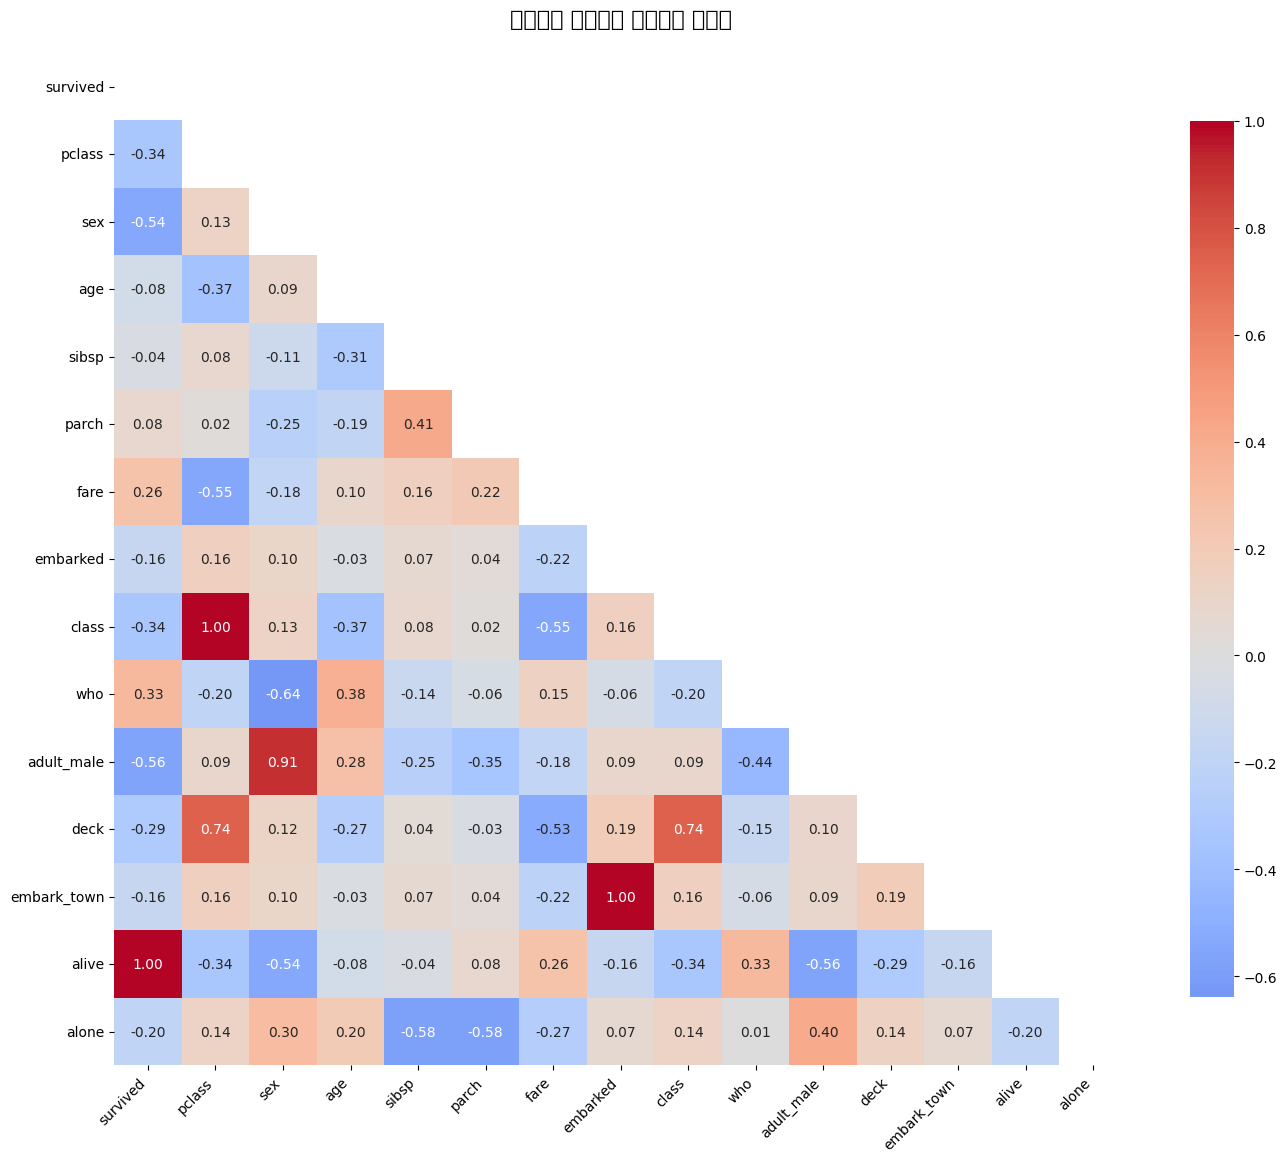

In [26]:
# 1. 전체 상관관계 히트맵
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # 상삼각 마스크

sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8})

plt.title('타이타닉 데이터셋 상관관계 히트맵', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# 6. 상관관계 분석 결과 요약
print("="*60)
print("상관관계 분석 결과 요약")
print("="*60)

# 강한 상관관계 특성 (타겟과 |r| > 0.3)
strong_corr = target_corr[target_corr > 0.3]
print(f"\n🔥 타겟과 강한 상관관계 특성 (|r| > 0.3): {len(strong_corr)}개")
for feature, corr in strong_corr.sort_values(ascending=False).items():
    print(f"  ✅ {feature:<12}: {corr:.3f}")

# 약한 상관관계 특성 (타겟과 |r| < 0.1)
weak_corr = target_corr[target_corr < 0.1]
print(f"\n⚠️ 타겟과 약한 상관관계 특성 (|r| < 0.1): {len(weak_corr)}개")
for feature, corr in weak_corr.sort_values(ascending=True).items():
    print(f"  ❌ {feature:<12}: {corr:.3f}")

# 다중공선성 문제 특성
if high_corr_pairs:
    print(f"\n🚨 다중공선성 위험 특성 쌍: {len(high_corr_pairs)}개")
    for pair in high_corr_pairs:
        print(f"  ⚠️ {pair['Feature1']} ↔ {pair['Feature2']}: {pair['Correlation']}")
else:
    print(f"\n✅ 다중공선성 문제 없음 (모든 특성 쌍이 |r| < 0.7)")

print(f"\n💡 특성 선택 권장사항:")
print(f"  - 강한 상관관계 특성들을 우선적으로 선택")
print(f"  - 약한 상관관계 특성들은 제거 고려")
print(f"  - 다중공선성이 있는 특성 쌍 중 하나는 제거 고려")


In [ ]:
# 상관관계 분석을 위한 데이터 전처리
def prepare_correlation_analysis(df, target_col='survived'):
    """상관관계 분석을 위한 데이터 전처리"""
    df_corr = df.copy()
    
    # 범주형 변수 인코딩
    categorical_cols = df_corr.select_dtypes(include=['object', 'category']).columns
    label_encoders_temp = {}
    
    for col in categorical_cols:
        if col != target_col:
            le = LabelEncoder()
            df_corr[col] = le.fit_transform(df_corr[col].astype(str))
            label_encoders_temp[col] = le
    
    # boolean 타입 변환
    bool_cols = df_corr.select_dtypes(include=['bool']).columns
    for col in bool_cols:
        df_corr[col] = df_corr[col].astype(int)
    
    return df_corr, label_encoders_temp

# 상관관계 분석용 데이터 준비
df_encoded, temp_encoders = prepare_correlation_analysis(df)
correlation_matrix = df_encoded.corr()

print("상관관계 매트릭스 준비 완료!")
print(f"데이터 크기: {df_encoded.shape}")
print(f"특성 개수: {len(correlation_matrix.columns)}")


In [ ]:
y_pred2 = rf_model.predict(X2)


In [ ]:
df['predicted_survived'] = y_pred2


In [ ]:
df


In [ ]:
df[df['survived'] != df['predicted_survived']]


In [ ]:
y_encoder.inverse_transform(y_pred2)
